In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# 定义 AlexNet 模型
class AlexNetFashionMNIST(nn.Module):
    def __init__(self):
        super(AlexNetFashionMNIST, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小以适应 AlexNet 的输入
    transforms.Grayscale(num_output_channels=1),  # 将图像转换为灰度图像（1个通道）
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# # 加载数据集（使用10%的数据集）
# train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# train_set.data = train_set.data[:6000]
# train_set.targets = train_set.targets[:6000]
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# 加载数据集
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建模型、损失函数和优化器，并将模型加载到 GPU 上
model = AlexNetFashionMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 2
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # 将数据加载到 GPU 上
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch 100] loss: 1.387
[Epoch 1, Batch 200] loss: 0.677
[Epoch 1, Batch 300] loss: 0.590
[Epoch 1, Batch 400] loss: 0.530
[Epoch 1, Batch 500] loss: 0.500
[Epoch 1, Batch 600] loss: 0.461
[Epoch 1, Batch 700] loss: 0.449
[Epoch 1, Batch 800] loss: 0.429
[Epoch 1, Batch 900] loss: 0.437
[Epoch 2, Batch 100] loss: 0.398
[Epoch 2, Batch 200] loss: 0.428
[Epoch 2, Batch 300] loss: 0.410
[Epoch 2, Batch 400] loss: 0.389
[Epoch 2, Batch 500] loss: 0.390
[Epoch 2, Batch 600] loss: 0.380
[Epoch 2, Batch 700] loss: 0.367
[Epoch 2, Batch 800] loss: 0.365
[Epoch 2, Batch 900] loss: 0.360
Finished Training


In [10]:
# 保存模型
torch.save(model.state_dict(), 'alexnet_FashionMNIST_model.pth')

In [11]:
# 加载模型
model = AlexNetFashionMNIST()
model.load_state_dict(torch.load('alexnet_fashionmnist_model.pth'))

# 测试模型
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


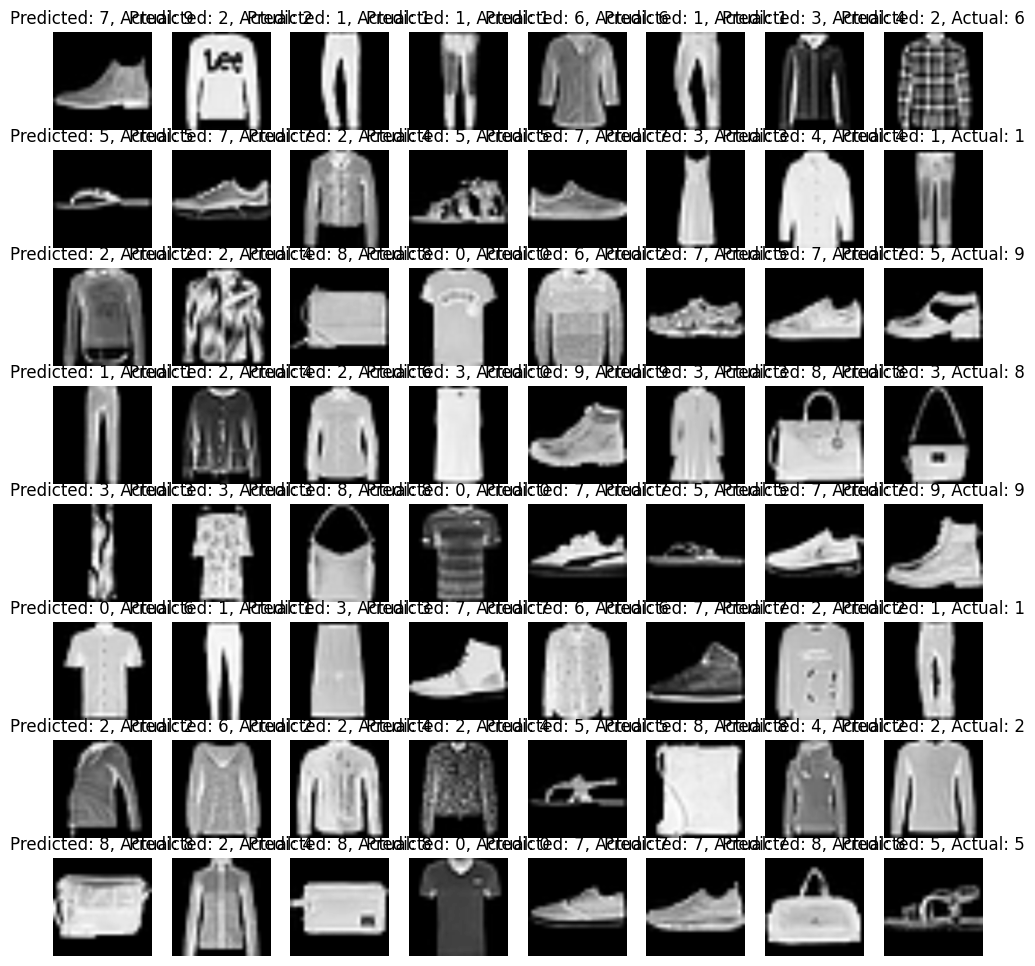

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 测试模型并可视化预测结果
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # 可视化预测结果
        fig, axes = plt.subplots(8, 8, figsize=(12, 12))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i][0], cmap='gray')
            ax.set_title(f'P: {predicted[i]}, A: {labels[i]}')
            ax.axis('off')
        plt.show()

        break  # 只显示一个 batch 的预测结果
